<a href="https://www.kaggle.com/code/marioshadjiantonis/spaceship-titanic?scriptVersionId=93370287" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Spaceship Titanic
The goal of this notebook is to predict which passengers of Spaceship Titanic were transported in an alternate dimension.  It is a submission for the corresponding [Kaggle competition](https://www.kaggle.com/competitions/spaceship-titanic/overview).  After some data cleaning and exploratory analysis, we apply and evaluate several machine learning algorithms to predict the labels for the competition data.

In [1]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('dark')

# Read data and some EDA

In [2]:
# read data in a Pandas DataFrame
def get_data(path):
    df = pd.read_csv(path)
    # Calculate total spending
    df['TotalSpending'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].apply('sum', axis='columns')
    # Extract useful features from cabin number
    df['Deck'] = df['Cabin'].str[0]
    df['Side'] = df['Cabin'].str[-1]
    # Extract age group
    #df.loc[df['Age'] < 18, 'AgeGroup'] = 'Under18'
    #df.loc[df['Age'] >= 18, 'AgeGroup'] = 'Adult'
    # Find whether they travel with family
    df['GroupId'] = df['PassengerId'].str[:4]
    df['LastName'] = df['Name'].str.split().map(lambda x: x[-1], na_action='ignore')
    df['PeopleInGroup'] = df.groupby('GroupId')['PassengerId'].transform('count')
    df['LastNamesInGroup'] = df.groupby('GroupId')['LastName'].transform('nunique')
    df['GroupHasUnnamed'] = df.groupby('GroupId')['LastName'].transform('count') < df['PeopleInGroup']
    df['WithFamily'] = (df['PeopleInGroup'] > 1) & (df['LastNamesInGroup'] < df['PeopleInGroup']) & ~df['GroupHasUnnamed']
    df.loc[df['GroupHasUnnamed'], 'WithFamily'] = np.nan
    # drop helper columns
    df.drop(columns=['GroupId', 'LastName', 'LastNamesInGroup', 'GroupHasUnnamed'], inplace=True)
    # Drop Cabin and Name columns
    df.drop(columns=['Cabin', 'Name'], inplace=True)
    # Set Passenger id as the index
    df.set_index('PassengerId', inplace=True)
    return df

path = '/kaggle/input/spaceship-titanic/train.csv'
titanic_df = get_data(path)
titanic_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalSpending,Deck,Side,PeopleInGroup,WithFamily
PassengerId,,,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,B,P,1,False
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,736.0,F,S,1,False
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,10383.0,A,S,2,True
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,5176.0,A,S,2,True
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1091.0,F,S,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,8536.0,A,P,1,False
9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,G,S,1,False
9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,1873.0,G,S,1,False


In [3]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8492 non-null   object 
 1   CryoSleep      8476 non-null   object 
 2   Destination    8511 non-null   object 
 3   Age            8514 non-null   float64
 4   VIP            8490 non-null   object 
 5   RoomService    8512 non-null   float64
 6   FoodCourt      8510 non-null   float64
 7   ShoppingMall   8485 non-null   float64
 8   Spa            8510 non-null   float64
 9   VRDeck         8505 non-null   float64
 10  Transported    8693 non-null   bool   
 11  TotalSpending  8693 non-null   float64
 12  Deck           8494 non-null   object 
 13  Side           8494 non-null   object 
 14  PeopleInGroup  8693 non-null   int64  
 15  WithFamily     8265 non-null   object 
dtypes: bool(1), float64(7), int64(1), object(7)
memory usage: 1.1+ MB


In [4]:
titanic_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpending,PeopleInGroup
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,1440.866329,2.035546
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2803.045694,1.596347
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,716.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1441.000000,3.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000,8.000000


<Figure size 1080x1080 with 0 Axes>

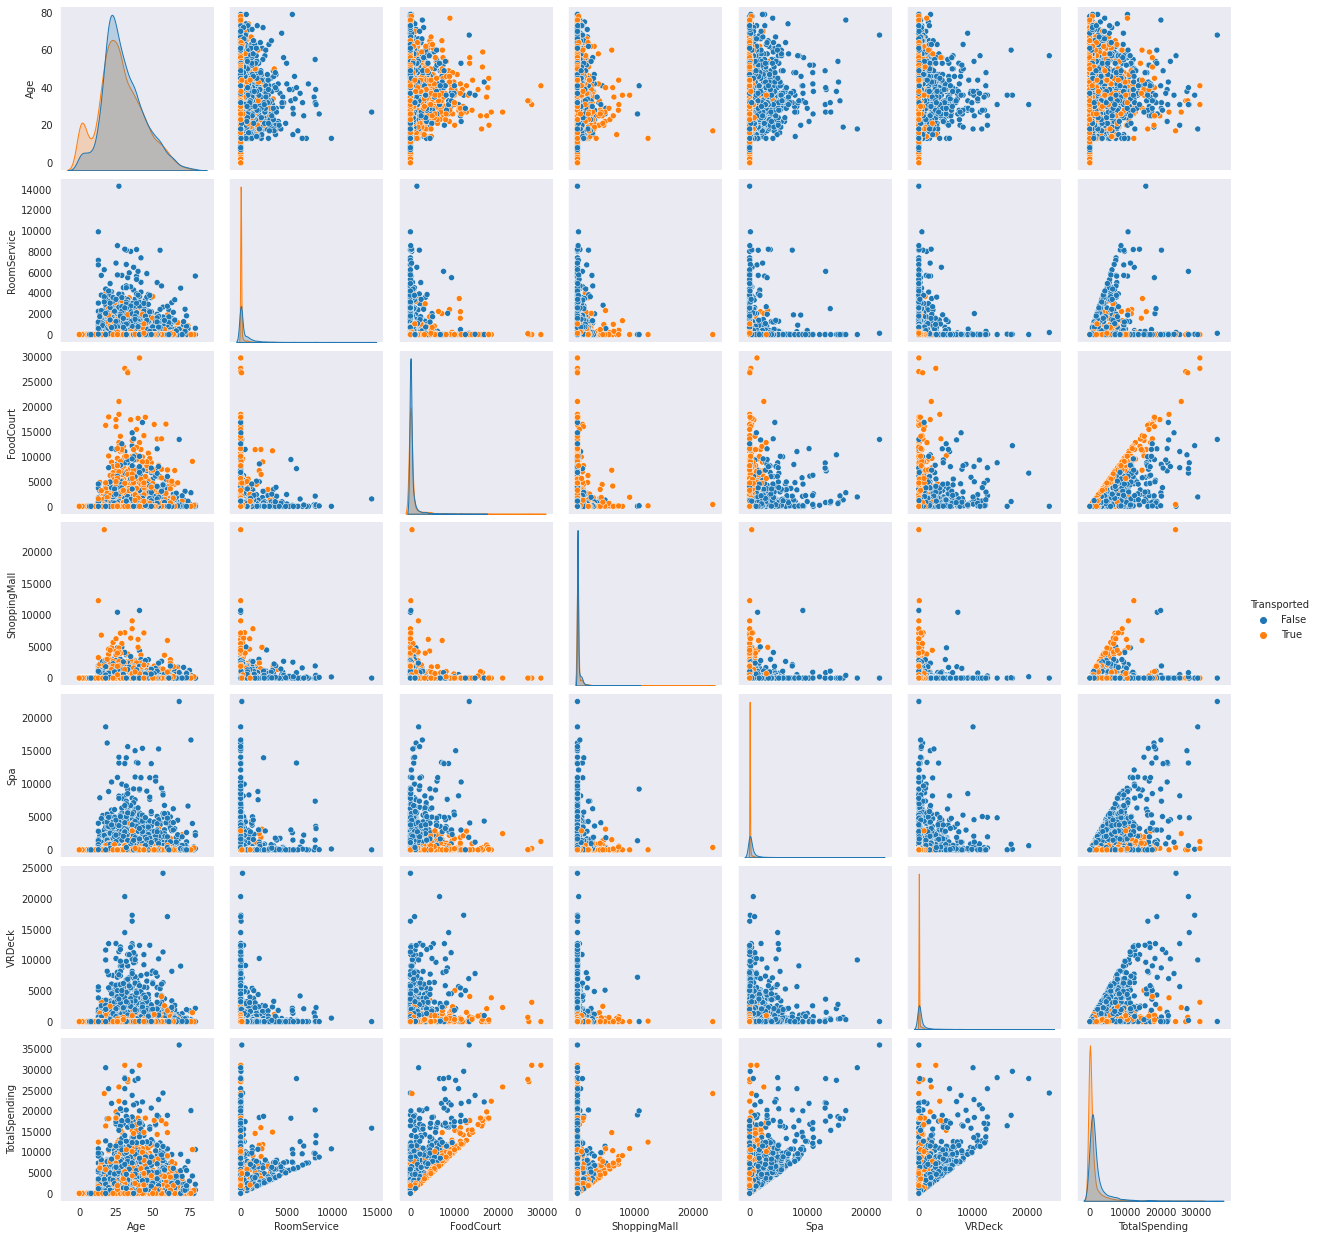

In [5]:
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpending']
plt.figure(figsize=(15,15))
sns.pairplot(data=titanic_df[numerical_columns + ['Transported']], hue='Transported')

In [6]:
categorical_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'PeopleInGroup', 'WithFamily']#, 'AgeGroup']
for col in categorical_columns:
    print(titanic_df[col].value_counts())

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64
False    5439
True     3037
Name: CryoSleep, dtype: int64
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64
False    8291
True      199
Name: VIP, dtype: int64
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64
S    4288
P    4206
Name: Side, dtype: int64
1    4805
2    1682
3    1020
4     412
5     265
7     231
6     174
8     104
Name: PeopleInGroup, dtype: int64
False    4829
True     3436
Name: WithFamily, dtype: int64


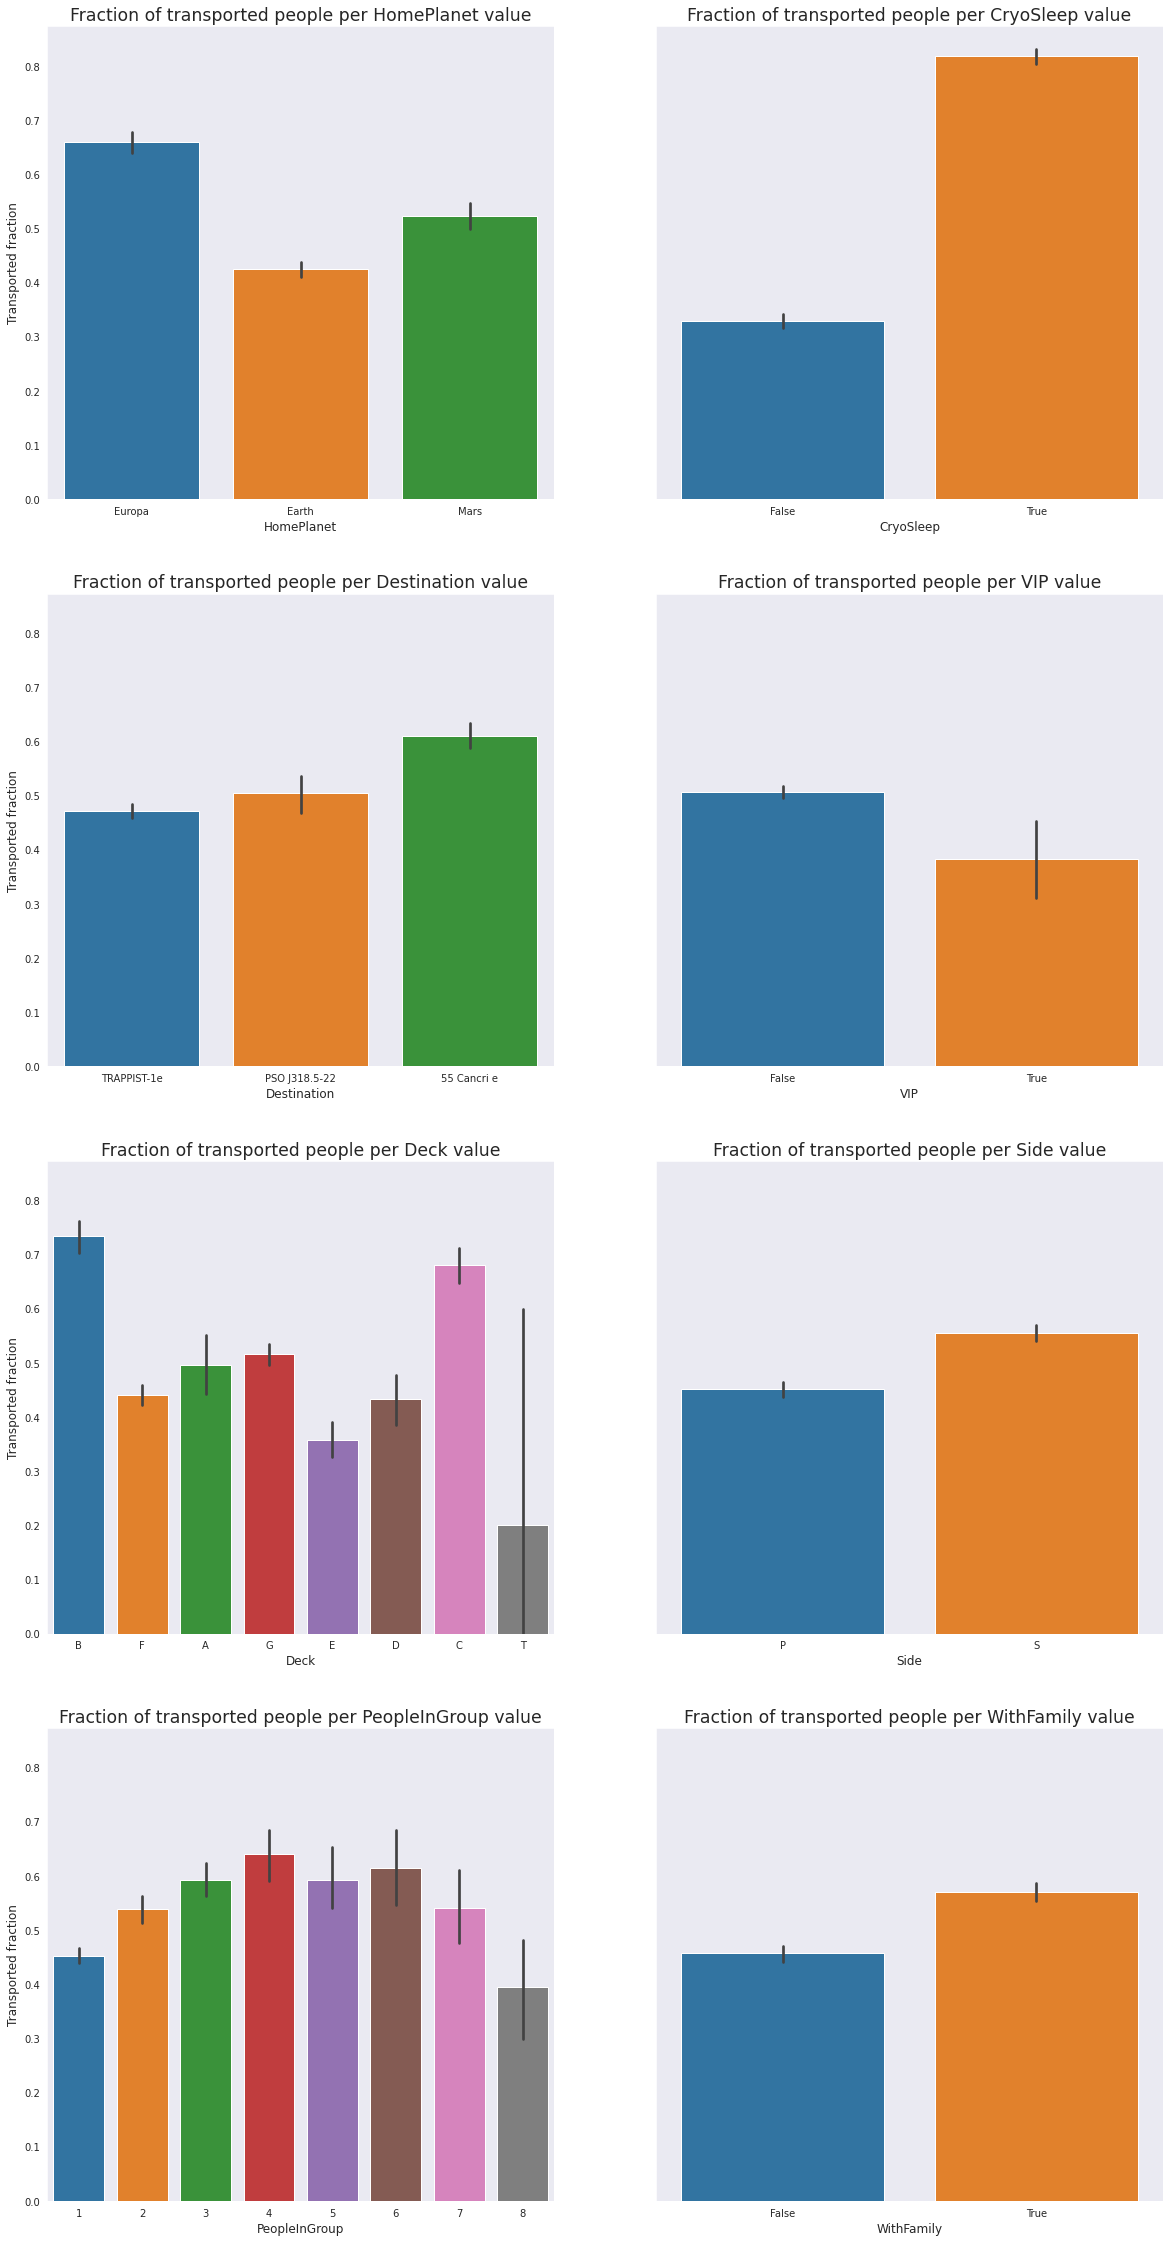

In [7]:
fig, axs = plt.subplots(4, 2, figsize=(20,40), sharey=True)

for i, col in enumerate(categorical_columns):
    ax = axs[i // 2, i % 2]
    sns.barplot(data=titanic_df, x=col, y='Transported', ax=ax)
    ax.set_xlabel(col, size='large')
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel('Transported fraction', size='large')
    else:
        ax.set_ylabel('')
    ax.set_title('Fraction of transported people per {} value'.format(col), size='xx-large')
plt.show()

#### Observations: 
1. There are some missing values that need to be taken care of.
2. Columns HomePlanet and Destination are categorical.
3. All ameneties columns are heavily skewed to the right.
4. Most passengers that are transported seem to have low RoomService, Spa and VRDeck values.
5. From the categorical features, the most important one seems to be CryoSleep since about 80% of those in cryo sleep seem to have been transported while only about 35% of those not in cryo sleep  have.
6. There are at least two distinct age groups.  We can extract a categorical variable.

## Data Cleaning - Feature Engineering

Before applying any transformation we separate the data into a training and a testign set.

In [8]:
from sklearn.model_selection import train_test_split

X = titanic_df[numerical_columns + categorical_columns]
y = titanic_df['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

Steps for data cleaning:
1. Impute missing values of numerical features with the median of each one
1. Apply log1p to the 5 amenities features
2. Standard scale all numerical features
3. One-hot encode categorical features

In [9]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline  import make_pipeline

amenities_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(func=np.log1p, inverse_func=np.expm1),
    StandardScaler()
)

amenities = [col for col in numerical_columns if col != 'Age']

age_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

col_transformer = make_column_transformer(
    (amenities_transformer, amenities),
    (age_transformer, ['Age']),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_columns)
)

col_transformer

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['RoomService', 'FoodCourt', 'ShoppingMall',
                                  'Spa', 'VRDeck', 'TotalSpending']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                

# Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier

rand_forest_pipe = make_pipeline(col_transformer, RandomForestClassifier())

rand_forest_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck', 'TotalS

In [11]:
# Find optimal parameters for the model
from sklearn.model_selection import GridSearchCV

parameter_grid = {
    'randomforestclassifier__n_estimators': [5, 10, 20, 50, 100, 200],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__bootstrap': [True, False]
}

gridRandForest = GridSearchCV(rand_forest_pipe, parameter_grid, scoring='accuracy', verbose=3, n_jobs=4)

gridRandForest.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
              

In [12]:
# Best parameters for the model
display(gridRandForest.best_params_)

{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__n_estimators': 100}

In [13]:
#Evaluate model using test data
display('Accuracy score: {:.4f}'.format(gridRandForest.score(X_test, y_test)))

'Accuracy score: 0.8013'

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

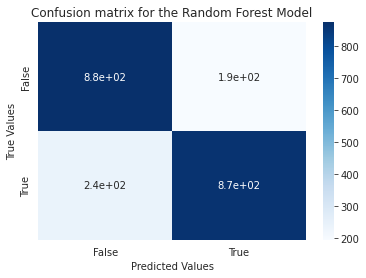

In [14]:
from sklearn.metrics import confusion_matrix

#Create and display a confusion matrix
cf_matrix = confusion_matrix(y_test, gridRandForest.predict(X_test))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion matrix for the Random Forest Model')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('True Values')
ax.set_xticklabels(['False', 'True'])
ax.set_yticklabels(['False', 'True'])

In [15]:
# Prepare data for submission

path = '/kaggle/input/spaceship-titanic/test.csv'
sub_df = get_data(path)
sub_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpending,Deck,Side,PeopleInGroup,WithFamily
PassengerId,,,,,,,,,,,,,,,
0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,0.0,G,S,1,False
0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,2832.0,F,S,1,False
0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,0.0,C,S,1,False
0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,7418.0,C,S,1,False
0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,645.0,F,S,1,False


In [16]:
predictions_df = pd.DataFrame({
    'Transported': gridRandForest.predict(sub_df)
}, index=sub_df.index)
predictions_df.head()

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [17]:
predictions_df.to_csv('./predictionsRFC.csv')

# Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

log_reg_pipe = make_pipeline(col_transformer, LogisticRegression())

log_reg_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck', 'TotalS

In [19]:
parameter_grid = [{
    'logisticregression__penalty': ['l1'],
    'logisticregression__solver': ['liblinear', 'saga'],
    'logisticregression__warm_start': [True, False]
}, {
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__warm_start': [True, False]
}, {
    'logisticregression__penalty': ['none'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'logisticregression__warm_start': [True, False]
}, {
    'logisticregression__penalty': ['elasticnet'],
    'logisticregression__solver': ['saga'],
    'logisticregression__warm_start': [True, False],
    'logisticregression__l1_ratio': np.arange(0.1, 1, 0.1)
}]

gridLogReg = GridSearchCV(log_reg_pipe, parameter_grid, scoring='accuracy', verbose=3, n_jobs=4)

gridLogReg.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 4/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=5;, score=0.740 total time=   0.2s
[CV 3/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=10;, score=0.766 total time=   0.2s
[CV 2/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=20;, score=0.791 total time=   0.4s
[CV 5/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=20;, score=0.782 total time=   0.4s
[CV 4/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=50;, score=0.779 total time=   0.6s
[CV 3/5] END randomforestclassifier__bootstrap=True, randomforestclassifier__criterion=gini, randomforestclas

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
              

In [20]:
# Best parameters for the model
gridLogReg.best_params_

{'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear',
 'logisticregression__warm_start': True}

In [21]:
#Evaluate model using test data
display('Accuracy score: {:.4f}'.format(gridLogReg.score(X_test, y_test.astype(int))))

'Accuracy score: 0.7856'

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

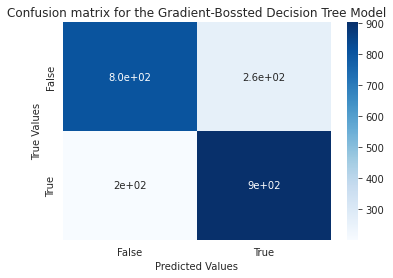

In [22]:
#Create and display a confusion matrix
cf_matrix = confusion_matrix(y_test, gridLogReg.predict(X_test))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion matrix for the Gradient-Bossted Decision Tree Model')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('True Values')
ax.set_xticklabels(['False', 'True'])
ax.set_yticklabels(['False', 'True'])

In [23]:
predictions_df = pd.DataFrame({
    'Transported': gridLogReg.predict(sub_df)
}, index=sub_df.index)
predictions_df.head()

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [24]:
predictions_df.to_csv('./predictionsLogReg.csv')

# Gradient Boosted Decision Tree (XGBoost)
Let's check if this  model performs better

In [25]:
from xgboost import XGBClassifier

xgb_pipe = make_pipeline(col_transformer, XGBClassifier(use_label_encoder=False, verbosity=0, n_jobs=1))

xgb_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck', 'TotalS

In [26]:
parameter_grid = {
    'xgbclassifier__n_estimators': [5, 10, 20, 50, 100, 200, 300, 400],
    'xgbclassifier__learning_rate': np.arange(0.04, 0.09, 0.01),
    'xgbclassifier__booster': ['gbtree']
}

gridXGB = GridSearchCV(xgb_pipe, parameter_grid, scoring='accuracy', verbose=3, n_jobs=4)

gridXGB.fit(X_train, y_train.astype(int)) # labels are recommended to be integers

Fitting 5 folds for each of 40 candidates, totalling 200 fits

[CV 4/5] END logisticregression__penalty=none, logisticregression__solver=sag, logisticregression__warm_start=False;, score=0.769 total time=   0.5s
[CV 3/5] END logisticregression__penalty=none, logisticregression__solver=saga, logisticregression__warm_start=True;, score=0.760 total time=   0.7s
[CV 3/5] END logisticregression__penalty=none, logisticregression__solver=saga, logisticregression__warm_start=False;, score=0.760 total time=   0.7s
[CV 3/5] END logisticregression__l1_ratio=0.1, logisticregression__penalty=elasticnet, logisticregression__solver=saga, logisticregression__warm_start=True;, score=0.761 total time=   1.0s
[CV 2/5] END logisticregression__l1_ratio=0.1, logisticregression__penalty=elasticnet, logisticregression__solver=saga, logisticregression__warm_start=False;, score=0.762 total time=   1.0s
[CV 1/5] END logisticregression__l1_ratio=0.2, logisticregression__penalty=elasticnet, logisticregression__sol

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
              

In [27]:
# Best parameters for the model
gridXGB.best_params_

{'xgbclassifier__booster': 'gbtree',
 'xgbclassifier__learning_rate': 0.07,
 'xgbclassifier__n_estimators': 300}

In [28]:
#Evaluate model using test data
display('Accuracy score: {:.4f}'.format(gridXGB.score(X_test, y_test.astype(int))))

'Accuracy score: 0.8114'

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

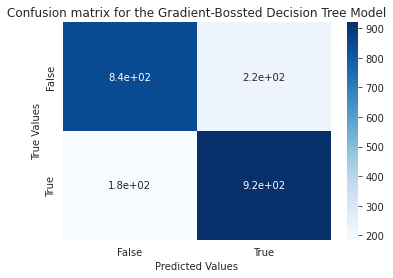

In [29]:
#Create and display a confusion matrix
cf_matrix = confusion_matrix(y_test, gridXGB.predict(X_test))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion matrix for the Gradient-Bossted Decision Tree Model')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('True Values')
ax.set_xticklabels(['False', 'True'])
ax.set_yticklabels(['False', 'True'])

In [30]:
predictions_df = pd.DataFrame({
    'Transported': gridXGB.predict(sub_df)
}, index=sub_df.index)
predictions_df['Transported'] = predictions_df['Transported'].astype(bool)
predictions_df.head()

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [31]:
predictions_df.to_csv('./predictionsXGB.csv')

# k-Nearest Naeighbors
Predict labels using a kNN classifier

In [32]:
from sklearn.neighbors  import KNeighborsClassifier

knn_pipe = make_pipeline(col_transformer, KNeighborsClassifier())
knn_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck', 'TotalS

In [33]:
parameter_grid = {
    'kneighborsclassifier__n_neighbors': list(range(15, 30)),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__algorithm': ['ball_tree', 'kd_tree', 'brute']
}

gridKNN = GridSearchCV(knn_pipe, parameter_grid, scoring='accuracy', verbose=3, n_jobs=4)

gridKNN.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits

[CV 2/5] END xgbclassifier__booster=gbtree, xgbclassifier__learning_rate=0.060000000000000005, xgbclassifier__n_estimators=5;, score=0.772 total time=   0.3s
[CV 3/5] END xgbclassifier__booster=gbtree, xgbclassifier__learning_rate=0.060000000000000005, xgbclassifier__n_estimators=5;, score=0.804 total time=   0.3s
[CV 4/5] END xgbclassifier__booster=gbtree, xgbclassifier__learning_rate=0.060000000000000005, xgbclassifier__n_estimators=5;, score=0.780 total time=   0.3s
[CV 5/5] END xgbclassifier__booster=gbtree, xgbclassifier__learning_rate=0.060000000000000005, xgbclassifier__n_estimators=5;, score=0.781 total time=   0.3s
[CV 1/5] END xgbclassifier__booster=gbtree, xgbclassifier__learning_rate=0.060000000000000005, xgbclassifier__n_estimators=10;, score=0.790 total time=   0.4s
[CV 2/5] END xgbclassifier__booster=gbtree, xgbclassifier__learning_rate=0.060000000000000005, xgbclassifier__n_estimators=10;, score=0.780 total 

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
              

In [34]:
gridKNN.best_params_

{'kneighborsclassifier__algorithm': 'ball_tree',
 'kneighborsclassifier__n_neighbors': 25,
 'kneighborsclassifier__weights': 'uniform'}

In [35]:
#Evaluate model using test data
display('Accuracy score: {:.4f}'.format(gridKNN.score(X_test, y_test.astype(int))))

'Accuracy score: 0.7971'

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

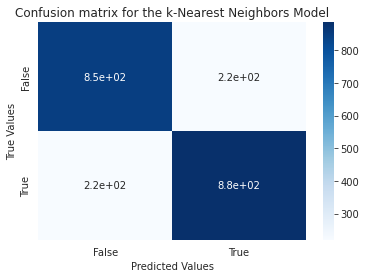

In [36]:
#Create and display a confusion matrix
cf_matrix = confusion_matrix(y_test, gridKNN.predict(X_test))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion matrix for the k-Nearest Neighbors Model')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('True Values')
ax.set_xticklabels(['False', 'True'])
ax.set_yticklabels(['False', 'True'])

In [37]:
predictions_df = pd.DataFrame({
    'Transported': gridKNN.predict(sub_df)
}, index=sub_df.index)
predictions_df['Transported'] = predictions_df['Transported'].astype(bool)
predictions_df.head()

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,False
0023_01,True


In [38]:
predictions_df.to_csv('./predictionsKNN.csv')

# Artificial neural network

In [39]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.losses import mean_squared_error

def getDNN_model(features = 4, hidden_layer_units = 25, hidden_layers = 1, optimizer = 'adam'):
    """
    Return a compiled Deep Neural Network model
    
    Arguments:
    features: The numver of features in the input data
    hidden_layer_units: The number of units in each hidden layer of the network
    hidden_layers: The number of hidden layers in the network
    optimizer: The optimizer used by the network
    """

    model = Sequential()

    #Input layer
    model.add(Dense(1 + features, input_shape=(features,), activation='relu', kernel_initializer='normal'))
    for _ in range(hidden_layers):
        #Hidden layers
        model.add(Dense(hidden_layer_units, activation='relu', kernel_initializer='normal'))
    #Output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))
    

    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    
    return model

In [40]:
from keras.wrappers.scikit_learn import KerasClassifier

dnn_pipe = make_pipeline(col_transformer, KerasClassifier(build_fn=getDNN_model, verbose=0))

parameter_grid = {
    'kerasclassifier__optimizer': ['RMSprop', 'Adam', 'Adamax', 'Nadam'],
    'kerasclassifier__hidden_layers': list(range(1, 4)),
    'kerasclassifier__hidden_layer_units': [20, 50, 100],
    'kerasclassifier__epochs' : [10, 20, 30],
    'kerasclassifier__features': [col_transformer.fit_transform(X_train).shape[-1]]
}

gridDNN = GridSearchCV(dnn_pipe, parameter_grid, scoring='accuracy', verbose=3, n_jobs=4)

gridDNN.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


2022-04-18 17:52:42.393564: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-04-18 17:52:42.399673: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-04-18 17:52:42.423213: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-04-18 17:52:42.465954: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-04-18 17:52:42.614000: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-18 17:52:42.613993: I te


[CV 5/5] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=22, kneighborsclassifier__weights=uniform;, score=0.785 total time=   0.4s
[CV 4/5] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=22, kneighborsclassifier__weights=distance;, score=0.761 total time=   0.4s
[CV 3/5] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=23, kneighborsclassifier__weights=uniform;, score=0.776 total time=   0.4s
[CV 2/5] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=23, kneighborsclassifier__weights=distance;, score=0.773 total time=   0.4s
[CV 1/5] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=24, kneighborsclassifier__weights=uniform;, score=0.788 total time=   0.4s
[CV 5/5] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=24, kneighborsclassifier__weights=uniform;, score=0.789 total time=   0.4s
[CV 4/5] END kneighborsclassifi

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reach


[CV 2/5] END kneighborsclassifier__algorithm=kd_tree, kneighborsclassifier__n_neighbors=27, kneighborsclassifier__weights=distance;, score=0.770 total time=   0.6s
[CV 1/5] END kneighborsclassifier__algorithm=kd_tree, kneighborsclassifier__n_neighbors=28, kneighborsclassifier__weights=uniform;, score=0.793 total time=   0.7s
[CV 5/5] END kneighborsclassifier__algorithm=kd_tree, kneighborsclassifier__n_neighbors=28, kneighborsclassifier__weights=uniform;, score=0.787 total time=   0.7s
[CV 4/5] END kneighborsclassifier__algorithm=kd_tree, kneighborsclassifier__n_neighbors=28, kneighborsclassifier__weights=distance;, score=0.760 total time=   0.7s
[CV 3/5] END kneighborsclassifier__algorithm=kd_tree, kneighborsclassifier__n_neighbors=29, kneighborsclassifier__weights=uniform;, score=0.771 total time=   0.7s
[CV 2/5] END kneighborsclassifier__algorithm=kd_tree, kneighborsclassifier__n_neighbors=29, kneighborsclassifier__weights=distance;, score=0.773 total time=   0.6s
[CV 1/5] END kneig

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reach


[CV 3/5] END kneighborsclassifier__algorithm=kd_tree, kneighborsclassifier__n_neighbors=29, kneighborsclassifier__weights=distance;, score=0.766 total time=   0.7s
[CV 2/5] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=15, kneighborsclassifier__weights=uniform;, score=0.771 total time=   0.4s
[CV 1/5] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=15, kneighborsclassifier__weights=distance;, score=0.769 total time=   0.5s
[CV 5/5] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=15, kneighborsclassifier__weights=distance;, score=0.770 total time=   0.6s
[CV 4/5] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=16, kneighborsclassifier__weights=uniform;, score=0.765 total time=   0.4s
[CV 3/5] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=16, kneighborsclassifier__weights=distance;, score=0.758 total time=   0.3s
[CV 2/5] END kneighborsclas

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/m

[CV 5/5] END kerasclassifier__epochs=10, kerasclassifier__features=44, kerasclassifier__hidden_layer_units=20, kerasclassifier__hidden_layers=1, kerasclassifier__optimizer=RMSprop;, score=0.787 total time=   4.2s
[CV 4/5] END kerasclassifier__epochs=10, kerasclassifier__features=44, kerasclassifier__hidden_layer_units=20, kerasclassifier__hidden_layers=1, kerasclassifier__optimizer=Adam;, score=0.777 total time=   4.4s
[CV 2/5] END kerasclassifier__epochs=10, kerasclassifier__features=44, kerasclassifier__hidden_layer_units=20, kerasclassifier__hidden_layers=1, kerasclassifier__optimizer=Adamax;, score=0.765 total time=   4.6s
[CV 5/5] END kerasclassifier__epochs=10, kerasclassifier__features=44, kerasclassifier__hidden_layer_units=20, kerasclassifier__hidden_layers=1, kerasclassifier__optimizer=Adamax;, score=0.779 total time=   4.1s
[CV 4/5] END kerasclassifier__epochs=10, kerasclassifier__features=44, kerasclassifier__hidden_layer_units=20, kerasclassifier__hidden_layers=1, kerascla

2022-04-18 18:19:06.891366: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-18 18:19:06.998450: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
              

In [41]:
gridDNN.best_params_

{'kerasclassifier__epochs': 10,
 'kerasclassifier__features': 44,
 'kerasclassifier__hidden_layer_units': 100,
 'kerasclassifier__hidden_layers': 1,
 'kerasclassifier__optimizer': 'Adam'}

In [42]:
#Evaluate model using test data
display('Accuracy score: {:.4f}'.format(gridDNN.score(X_test, y_test)))

'Accuracy score: 0.8100'

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

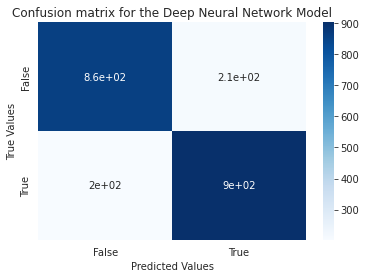

In [43]:
#Create and display a confusion matrix
cf_matrix = confusion_matrix(y_test, gridDNN.predict(X_test))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion matrix for the Deep Neural Network Model')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('True Values')
ax.set_xticklabels(['False', 'True'])
ax.set_yticklabels(['False', 'True'])

In [44]:
predictions_df = pd.DataFrame({
    'Transported': gridDNN.predict(sub_df).T[0]
}, index=sub_df.index)
predictions_df.head()

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [45]:
predictions_df.to_csv('./predictionsDNN.csv')

# Stack all models

In [46]:
from sklearn.ensemble import StackingClassifier

randForestParams = {k.split('__')[-1]: v for k, v in gridRandForest.best_params_.items()}
kNNParams = {k.split('__')[-1]: v for k, v in gridKNN.best_params_.items()}
LRParams = {k.split('__')[-1]: v for k, v in gridLogReg.best_params_.items()}
XGBParams = {k.split('__')[-1]: v for k, v in gridXGB.best_params_.items()}
DNNParams = {k.split('__')[-1]: v for k, v in gridDNN.best_params_.items()}

rf = RandomForestClassifier().set_params(**randForestParams)
knn = KNeighborsClassifier().set_params(**kNNParams)
lr = LogisticRegression().set_params(**LRParams)
xgb = XGBClassifier(use_label_encoder=False, verbosity=0).set_params(**XGBParams)
dnn = KerasClassifier(build_fn=getDNN_model, verbose=0).set_params(**DNNParams)
dnn._estimator_type = 'classifier'

stack_pipe = make_pipeline(col_transformer, StackingClassifier(estimators=[
    ('rf', rf),
    ('knn', knn),
    ('lr', lr),
    ('xgb', xgb),
    ('dnn', dnn)
]))

stack_pipe.fit(X_train, y_train.astype(int))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck', 'TotalS

In [47]:
display('Accuracy score: {:.4f}'.format(stack_pipe.score(X_test, y_test.astype(int))))

'Accuracy score: 0.8137'

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

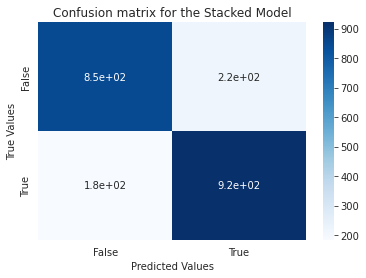

In [48]:
#Create and display a confusion matrix
cf_matrix = confusion_matrix(y_test, stack_pipe.predict(X_test))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion matrix for the Stacked Model')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('True Values')
ax.set_xticklabels(['False', 'True'])
ax.set_yticklabels(['False', 'True'])

In [49]:
predictions_df = pd.DataFrame({
    'Transported': stack_pipe.predict(sub_df).astype(bool)
}, index=sub_df.index)
predictions_df.head()

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [50]:
predictions_df.to_csv('./predictionsStack.csv')